In [1]:
import re
import numpy as np
import pandas as pd
import datasets
import openai 
import concurrent.futures

from typing import List, Dict
from tqdm import tqdm
from openai import OpenAI
from datasets import load_dataset

def multithread_openai_call(client, messages, model_name, max_workers=20, **kwargs):
    
    def call_openai(message: List[Dict[str, str]], **kwargs):
        response = client.chat.completions.create(
            model=model_name, 
            messages=message,
            **kwargs
        )
        # Handle multiple choices when n > 1
        if hasattr(response, 'choices') and len(response.choices) > 1:
            return [choice.message.content for choice in response.choices]
        else:
            return response.choices[0].message.content

    responses = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_message = {executor.submit(call_openai, message, **kwargs): i for i, message in enumerate(messages)}
        
        with tqdm(total=len(messages), desc="Processing messages") as pbar:
            for future in concurrent.futures.as_completed(future_to_message):
                message_idx = future_to_message[future]
                response = future.result()
                responses.append((message_idx, response))
                pbar.update(1)
    
    # Sort responses by original index and extract just the responses
    responses.sort(key=lambda x: x[0])
    return [r[1] for r in responses] 

client = OpenAI(base_url="http://22.1.41.53:30000/v1", api_key="EMPTY")

/root/miniconda3/envs/verl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
def extract_code_section(example):
    text = example["text"]
    pattern = r'<code>(.*?)</code>'
    matches = re.findall(pattern, text, re.DOTALL)
    code_text = matches[0].strip()
    # Extract file sections using regex
    file_pattern = r'\[start of (.*?)\](.*?)\[end of \1\]'
    matches = re.findall(file_pattern, code_text, re.DOTALL)
    
    # Build dictionary of file paths and contents
    files_dict = {}
    for file_path, content in matches:
        # Split content into lines and process each line
        processed_lines = []
        for line in content.split('\n'):
            # Skip empty lines or lines with just line numbers
            if not line.strip():
                continue
            # Remove line number prefix if it exists
            if ' ' in line:
                _, text = line.split(' ', 1)
                processed_lines.append(text)
            else:
                processed_lines.append(line)
        
        # Join processed lines and store in dictionary
        files_dict[file_path.strip()] = '\n'.join(processed_lines).strip()
    example["file_names"] = list(files_dict.keys())
    example["file_contents"] = list(files_dict.values())
    return example


In [16]:
from datasets import load_dataset
train_data = load_dataset("data/princeton-nlp/SWE-bench_oracle", split="train")
print(train_data)
print(train_data[0])

Dataset({
    features: ['instance_id', 'text', 'repo', 'base_commit', 'problem_statement', 'hints_text', 'created_at', 'patch', 'test_patch', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit'],
    num_rows: 18817
})
{'instance_id': 'Qiskit__qiskit-4465', 'text': 'You will be provided with a partial code base and an issue statement explaining a problem to resolve.\n<issue>\n`initialize` and `Statevector` don\'t play nicely\n<!-- ⚠️ If you do not respect this template, your issue will be closed -->\r\n<!-- ⚠️ Make sure to browse the opened and closed issues -->\r\n\r\n### Informations\r\n\r\n- **Qiskit Aer version**: 0.5.1\r\n- **Python version**: 3.7.3\r\n- **Operating system**: OSX\r\n\r\n### What is the current behavior?\r\n\r\nUsing `initialize` in a circuit and then running with `Statevector` results in the error "Cannot apply Instruction: reset"\r\n\r\n### Steps to reproduce the problem\r\n\r\n```\r\nimport qiskit as qk\r\nimport qiskit.quantum_info as qi\r\nf

In [17]:
train_data = train_data.map(extract_code_section, num_proc=10)

In [18]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

AGENTLESS_REPAIR = """We are currently solving the following issue within our repository. Here is the issue text:
--- BEGIN ISSUE ---
{problem_statement}
--- END ISSUE ---

Below are some code segments, each from a relevant file. One or more of these files may contain bugs.

--- BEGIN FILE ---
```
{content}
```
--- END FILE ---

Please first localize the bug based on the issue statement, and then generate *SEARCH/REPLACE* edits to fix the issue.

Every *SEARCH/REPLACE* edit must use this format:
1. The file path
2. The start of search block: <<<<<<< SEARCH
3. A contiguous chunk of lines to search for in the existing source code
4. The dividing line: =======
5. The lines to replace into the source code
6. The end of the replace block: >>>>>>> REPLACE

Here is an example:

```python
### mathweb/flask/app.py
<<<<<<< SEARCH
from flask import Flask
=======
import math
from flask import Flask
>>>>>>> REPLACE
```

Please note that the *SEARCH/REPLACE* edit REQUIRES PROPER INDENTATION. If you would like to add the line '        print(x)', you must fully write that out, with all those spaces before the code!
Wrap each *SEARCH/REPLACE* edit in a code block as shown in the example above. If you have multiple *SEARCH/REPLACE* edits, use a separate code block for each one.

Your response format must follow the template below:
<think>
Your thoughts or/and draft, like working through an exercise on scratch paper. Be as casual and as long as you want until you are confident to generate a correct solution.
</think>
<solution>
Final solution presented to the user.
</solution>"""

CODE_FILE = """
### {path}
{content}
""".strip()


In [19]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/mnt/data/models/Qwen2.5-Coder-7B-Instruct")

In [20]:
import unittest
from unidiff import PatchSet
import io


def apply_patch_to_code_dict(code_dict, patch_text):
    """
    Applies a unidiff patch to the given code_dict.

    Args:
        code_dict (dict): Dictionary where keys are file paths and values are file contents (as strings).
        patch_text (str): Unified diff patch in string format.

    Returns:
        dict: Updated code_dict after applying the patch.
    """
    patched_code_dict = code_dict.copy()
    # Strip XML-like tags and trailing newlines from the patch text
    patch_text = patch_text.strip()
    if patch_text.startswith('<patch>'):
        patch_text = patch_text[7:]
    if patch_text.endswith('</patch>'):
        patch_text = patch_text[:-8]
    # patch_text = patch_text.rstrip('\n')
    patch = PatchSet(io.StringIO(patch_text))

    for patched_file in patch:
        # Remove leading a/ or b/ prefixes in filenames
        path = patched_file.path
        original_text = code_dict.get(path)
        if original_text is None:
            raise ValueError(f"File {path} not found in code_dict {code_dict.keys()}.")

        original_lines = original_text.splitlines(keepends=True)
        patched_lines = []
        i = 0  # Pointer for original_lines

        for hunk in patched_file:
            # Add lines before hunk
            while i < hunk.source_start - 1 and i < len(original_lines):
                patched_lines.append(original_lines[i])
                i += 1

            # Apply hunk changes
            for line in hunk:
                if line.is_context:
                    if i < len(original_lines):
                        patched_lines.append(original_lines[i])
                        i += 1
                elif line.is_removed:
                    if i < len(original_lines):
                        i += 1  # Skip the line (removal)
                elif line.is_added:
                    patched_lines.append(line.value)

        # Add remaining lines after last hunk
        patched_lines.extend(original_lines[i:])

        # Update the file content in the dict
        patched_code_dict[path] = ''.join(patched_lines)

    return patched_code_dict

In [21]:
def make_map_fn(split, data_source, tokenizer):

    def process_fn(example, idx):
        problem_statement = example["problem_statement"]
        file_names = example["file_names"]
        file_contents = example["file_contents"]
        code_dict = {file_name: content for file_name, content in zip(file_names, file_contents)}

        file_prompts = [CODE_FILE.format(path=name, content=content) for name, content in zip(file_names, file_contents)]
        file_prompts = "\n\n".join(file_prompts)
        prompt = AGENTLESS_REPAIR.format(problem_statement=problem_statement, content=file_prompts)
        messages = [dict(role="user", content=prompt)]
        message_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        token_length = len(tokenizer.encode(message_prompt))

        from unidiff import UnidiffParseError
        try:
            answer = apply_patch_to_code_dict(code_dict, example["patch"])
            oracle_file_names = list(answer.keys())
            oracle_file_contents = list(answer.values())
        except ValueError as e:
            print(f"Found ValueError in {example['instance_id']}: {e}")
            oracle_file_names = []
            oracle_file_contents = []
        except UnidiffParseError as e:
            print(f"Found UnidiffParseError in {example['instance_id']}: {e}")
            oracle_file_names = []
            oracle_file_contents = []
            
        data = {
            "qwen_input_length": token_length,
            "data_source": data_source,
            "prompt": messages,
            "ability": "swe",
            "reward_model": {
                "style": "rule",
                "ground_truth": (oracle_file_names, oracle_file_contents),
            },
            "extra_info": {
                "split": split, "index": idx, "file_names": file_names, "file_contents": file_contents
            },
        }
        return data

    return process_fn

In [22]:
selected_data = train_data.select(range(100)).map(make_map_fn("train", "swe-oracle-search-replace", tokenizer), with_indices=True)

Map:   4%|▍         | 4/100 [00:00<00:02, 35.98 examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (53874 > 32768). Running this sequence through the model will result in indexing errors
Map:  27%|██▋       | 27/100 [00:02<00:04, 15.24 examples/s]

Found ValueError in apache__airflow-33043: File airflow/auth/managers/fab/views/roles_list.py not found in code_dict dict_keys(['README.md', 'airflow/www/fab_security/manager.py', 'airflow/www/fab_security/views.py', 'airflow/www/security.py']).


Map:  89%|████████▉ | 89/100 [00:07<00:00, 11.94 examples/s]

Found ValueError in PrefectHQ__prefect-856: File src/prefect/tasks/rss/__init__.py not found in code_dict dict_keys(['README.md', 'setup.py']).
Found ValueError in Qiskit__qiskit-1856: File qiskit/compiler/__init__.py not found in code_dict dict_keys(['README.md', 'examples/python/hello_quantum.py', 'examples/python/rippleadd.py', 'examples/python/teleport.py', 'examples/python/using_qiskit_terra_level_0.py', 'examples/python/using_qiskit_terra_level_1.py', 'qiskit/__init__.py', 'qiskit/converters/circuits_to_qobj.py', 'qiskit/qobj/__init__.py', 'qiskit/qobj/qobj.py', 'qiskit/qobj/run_config.py', 'qiskit/tools/__init__.py', 'qiskit/tools/compiler.py']).
Found ValueError in pandas-dev__pandas-39217: File pandas/io/parsers/__init__.py not found in code_dict dict_keys(['README.md', 'pandas/io/json/_json.py', 'pandas/io/parsers.py']).


Map:  98%|█████████▊| 98/100 [00:08<00:00, 14.72 examples/s]

Found ValueError in celery__celery-6629: File celery/backends/base.py not found in code_dict dict_keys([]).


Map: 100%|██████████| 100/100 [00:08<00:00, 11.21 examples/s]


In [29]:
print(selected_data[selected_data["instance_id"].index("PrefectHQ__prefect-856")]["text"])

You will be provided with a partial code base and an issue statement explaining a problem to resolve.
<issue>
Create RSS Tasks for Task Library


</issue>
<code>
[start of README.md]
1 <p align="center" style="margin-bottom:40px;">
2 <img src="https://uploads-ssl.webflow.com/5ba446b0e783e26d5a2f2382/5c942c9ca934ec5c88588297_primary-color-vertical.svg"  height=350 style="max-height: 350px;">
3 </p>
4 
5 <p align="center">
6 <a href=https://circleci.com/gh/PrefectHQ/prefect/tree/master>
7     <img src="https://circleci.com/gh/PrefectHQ/prefect/tree/master.svg?style=shield&circle-token=28689a55edc3c373486aaa5f11a1af3e5fc53344">
8 </a>
9 
10 <a href=https://github.com/ambv/black style="margin-left: 10px">
11     <img src="https://img.shields.io/badge/code%20style-black-000000.svg">
12 </a>
13 
14 <a href="https://gitter.im/prefectio/prefect?utm_source=badge&utm_medium=badge&utm_campaign=pr-badge&utm_content=badge">
15     <img src="https://badges.gitter.im/prefectio/prefect.svg">
16 </a>
1

In [10]:
len(train_data)

18817

In [11]:
train_data = train_data.filter(lambda x: len(x["reward_model"]["ground_truth"][0]) != 0)
print(len(train_data))
train_data.to_parquet("data/swe-oracle-search-replace/swe-oracle-search-replace-train.parquet")

Filter: 100%|██████████| 18817/18817 [00:25<00:00, 725.23 examples/s]


17302


Creating parquet from Arrow format: 100%|██████████| 18/18 [00:38<00:00,  2.12s/ba]


10645678972

In [12]:
train_data_16k = train_data.filter(lambda x: x["qwen_input_length"] <= 12288)
print(len(train_data_16k))
train_data_16k.to_parquet("data/swe-oracle-search-replace/swe-oracle-search-replace-train-16k.parquet")

Filter:   0%|          | 0/17302 [00:00<?, ? examples/s]

Filter: 100%|██████████| 17302/17302 [00:09<00:00, 1887.88 examples/s]


8300


Creating parquet from Arrow format: 100%|██████████| 9/9 [00:05<00:00,  1.78ba/s]


1087846309

In [13]:
train_data_24k = train_data.filter(lambda x: x["qwen_input_length"] <= 20480)
print(len(train_data_24k))
train_data_24k.to_parquet("data/swe-oracle-search-replace/swe-oracle-search-replace-train-24k.parquet")

Filter:  40%|████      | 7000/17302 [00:04<00:06, 1694.47 examples/s]

Filter: 100%|██████████| 17302/17302 [00:09<00:00, 1792.57 examples/s]


10910


Creating parquet from Arrow format: 100%|██████████| 11/11 [00:08<00:00,  1.29ba/s]


1991716174

In [14]:
train_data_32k = train_data.filter(lambda x: x["qwen_input_length"] <= 4096*7)
print(len(train_data_32k))
train_data_32k.to_parquet("data/swe-oracle-search-replace/swe-oracle-search-replace-train-32k.parquet")

Filter: 100%|██████████| 17302/17302 [00:09<00:00, 1794.63 examples/s]


12491


Creating parquet from Arrow format: 100%|██████████| 13/13 [00:11<00:00,  1.17ba/s]


2820285430

In [60]:
test_num = 100
messages = train_data_16k["prompt"][:test_num]
responses = multithread_openai_call(client, messages, "default", max_workers=20, max_tokens=4096)

Processing messages: 100%|██████████| 1000/1000 [34:37<00:00,  2.08s/it] 


In [63]:
rewards = []
for i in range(test_num):
    sample = train_data_16k[i]
    original_files = {file_name: file_content for file_name, file_content in zip(sample["file_names"], sample["file_contents"])}
    oracle_files = {file_name: file_content for file_name, file_content in zip(sample["reward_model"]["ground_truth"][0], sample["reward_model"]["ground_truth"][1])}
    reward, info = calculate_search_replace_reward(original_files, oracle_files, responses[4])
    rewards.append(reward)
print(rewards)
print(np.mean(rewards))

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.

In [15]:
test_data = load_dataset("data/princeton-nlp/SWE-bench_oracle", split="test")
test_data = test_data.map(extract_code_section, num_proc=10)

In [ ]:
test_data = test_data.map(make_map_fn("test", "swe-oracle-search-replace", tokenizer), with_indices=True, num_proc=10)
print(len(test_data))
test_data = test_data.filter(lambda x: len(x["reward_model"]["ground_truth"][0]) != 0)
print(len(test_data))
test_data.to_parquet("data/swe-oracle-search-replace/swe-oracle-search-replace-test.parquet")

In [43]:
file = """
def sort_list(lst):
    return sorted(lst)
""".strip()

oracle_file = """
def sort_list(lst: list[int]) -> list[int]:
    return sorted(lst)
""".strip()

context = {"example.py": file}
oracle = {"example.py": oracle_file}

output = """
<think>
...thoughts by LLM
</think>
<solution>
```python
### example.py
<<<<<<< SEARCH
def sort_list(lst):
=======
def sort_list(lst: list[int]) -> list[int]:
>>>>>>> REPLACE
```
</solution>
""".strip()

reward, metadata = calculate_search_replace_reward(context, oracle, output)
assert reward == 1.0
print(metadata)

{'similarities': [{'path': 'example.py', 'pred_change': '@@ -1,2 +1,2 @@\n-def sort_list(lst):\n+def sort_list(lst: list[int]) -> list[int]:\n     return sorted(lst)', 'oracle_change': '@@ -1,2 +1,2 @@\n-def sort_list(lst):\n+def sort_list(lst: list[int]) -> list[int]:\n     return sorted(lst)', 'similarity': 1.0}], 'thought': '...thoughts by LLM', 'answer': '```python\n### example.py\n<<<<<<< SEARCH\ndef sort_list(lst):\n=======\ndef sort_list(lst: list[int]) -> list[int]:\n>>>>>>> REPLACE\n```'}


In [38]:
test_data = load_dataset("data/princeton-nlp/SWE-bench_Verified", split="test")

In [5]:
instance_ids = test_data["instance_id"]
selected_idx = []
for instance_id in instance_ids:
    idx = data["instance_id"].index(instance_id)
    selected_idx.append(idx)
selected_data = data.select(selected_idx)


In [7]:
selected_data.to_parquet("data/swe-verified-with-oracle-prompts.parquet")

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00,  1.01ba/s]


42441221

In [9]:
patch = data["patch"][4]
py_count = patch.count('.py')
print(py_count)
print(patch)

12
<patch>
diff --git a/astropy/table/column.py b/astropy/table/column.py
--- a/astropy/table/column.py
+++ b/astropy/table/column.py
@@ -340,7 +340,9 @@ class ColumnInfo(BaseColumnInfo):
     This is required when the object is used as a mixin column within a table,
     but can be used as a general way to store meta information.
     """
-    attrs_from_parent = BaseColumnInfo.attr_names
+    attr_names = BaseColumnInfo.attr_names | {'groups'}
+    _attrs_no_copy = BaseColumnInfo._attrs_no_copy | {'groups'}
+    attrs_from_parent = attr_names
     _supports_indexing = True
 
     def new_like(self, cols, length, metadata_conflicts='warn', name=None):
diff --git a/astropy/table/groups.py b/astropy/table/groups.py
--- a/astropy/table/groups.py
+++ b/astropy/table/groups.py
@@ -214,7 +214,7 @@ def __len__(self):
 class ColumnGroups(BaseGroups):
     def __init__(self, parent_column, indices=None, keys=None):
         self.parent_column = parent_column  # parent Column
-        self.pare

In [3]:
def build_messages(problem):
    messages = [
        {"role": "user", "content": problem}
    ]
    return messages

In [4]:
messages = [build_messages(text) for text in data["text"]]
# responses = multithread_openai_call(client, messages, "default", max_workers=20)

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/mnt/data/models/Qwen2.5-Coder-7B-Instruct")

In [6]:
lengths = []
for output in tqdm(data["patch"]):
    lengths.append(len(tokenizer.encode(output)))

print(np.mean(lengths))
print(np.max(lengths))
print(np.min(lengths))

100%|██████████| 18817/18817 [03:50<00:00, 81.66it/s] 

4752.846415475368
40906212
6


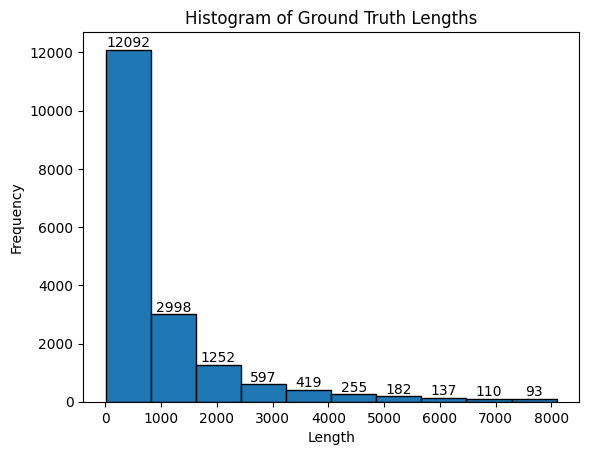

In [6]:
import matplotlib.pyplot as plt

lengths = [l for l in lengths if l <= 8096]

counts, bins, patches = plt.hist(lengths, bins=10, edgecolor='black')
plt.title('Histogram of Ground Truth Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Mark the count number of each bin
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count), 
             ha='center', va='bottom')

plt.show()


In [7]:
idx_4096 = [idx for idx, length in enumerate(lengths) if length <= 4096]
filtered_data = data.select(idx_4096)

In [8]:
def make_map_fn(split, data_source):

    def process_fn(example, idx):
        messages = [dict(role="user", content=example["text"])]
        answer = example["patch"]

        data = {
            "data_source": data_source,
            "prompt": messages,
            "ability": "swe",
            "reward_model": {
                "style": "rule",
                "ground_truth": answer,
            },
            "extra_info": {"split": split, "index": idx},
        }
        return data

    return process_fn

train_data = filtered_data.map(make_map_fn("train", "swe-oracle-unidiff"), with_indices=True)
train_data.to_parquet("data/swe-oracle-train/swe-oracle-unidiff-train.parquet")

Creating parquet from Arrow format: 100%|██████████| 18/18 [00:21<00:00,  1.17s/ba]


4322433985

In [9]:
from datasets import load_dataset
data = load_dataset("data/princeton-nlp/SWE-bench_oracle", split="test")

lengths = []
for output in tqdm(data["patch"]):
    lengths.append(len(tokenizer.encode(output)))

idx_4096 = [idx for idx, length in enumerate(lengths) if length <= 4096]
filtered_data = data.select(idx_4096)

test_data = filtered_data.map(make_map_fn("test", "swe-oracle-unidiff"), with_indices=True)
test_data.to_parquet("data/swe-oracle-train/swe-oracle-unidiff-test.parquet")

  4%|▍         | 93/2294 [00:00<00:04, 442.42it/s]

Creating parquet from Arrow format: 100%|██████████| 3/3 [00:01<00:00,  1.57ba/s]


408384641

In [8]:
messages = [build_messages(text) for text in filtered_data["text"]]

In [9]:
lengths = []
for message in tqdm(messages):
    prompt = tokenizer.apply_chat_template(message, tokenize=False)
    lengths.append(len(tokenizer.encode(prompt)))

print(np.mean(lengths))
print(np.max(lengths))
print(np.min(lengths))


100%|██████████| 17373/17373 [25:35<00:00, 11.31it/s] 

36198.971737753986
526695
899


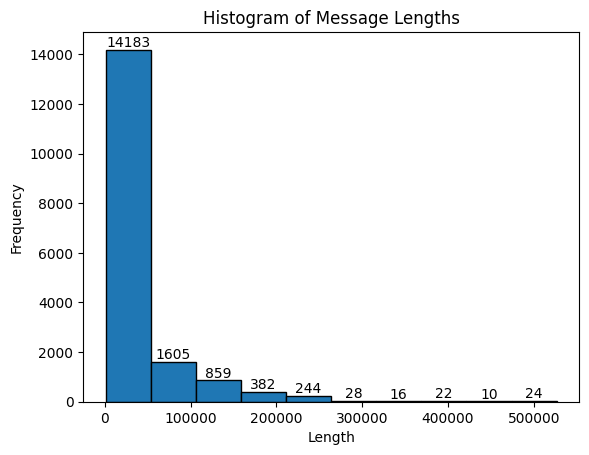

In [10]:
import matplotlib.pyplot as plt

counts, bins, patches = plt.hist(lengths, bins=10, edgecolor='black')
plt.title('Histogram of Message Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Mark the count number of each bin
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count), 
             ha='center', va='bottom')

plt.show()


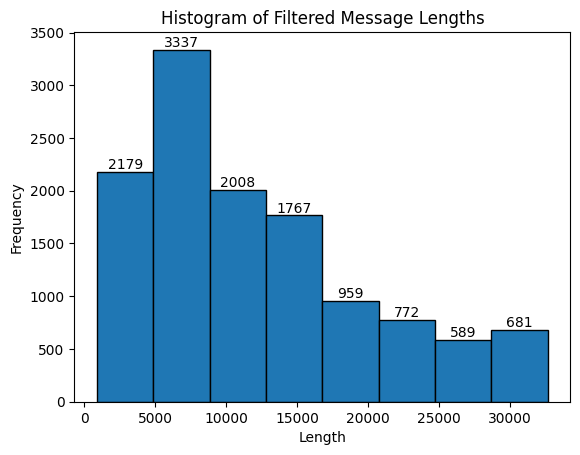

In [11]:
# Filter data with lengths > 32768
filtered_lengths = [length for length in lengths if length <= 32768]

# Redraw the histogram
counts, bins, patches = plt.hist(filtered_lengths, bins=8, edgecolor='black')
plt.title('Histogram of Filtered Message Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Mark the count number of each bin
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count), 
             ha='center', va='bottom')

plt.show()


In [12]:
print(len([length for length in lengths if length <= 32768]) / len(data))
print(len([length for length in lengths if length <= 25600]) / len(data))


0.6532390923101451
0.5907955572089069


In [70]:
train_test = data.train_test_split(test_size=0.2)
train_data = train_test["train"]
test_data = train_test["test"]
print(len(train_data), len(test_data))

1835 459


In [74]:
def make_map_fn(split, data_source):

    def process_fn(example, idx):
        messages = [dict(role="user", content=example["text"])]
        answer = example["patch"]

        data = {
            "data_source": data_source,
            "prompt": messages,
            "ability": "swe",
            "reward_model": {
                "style": "rule",
                "ground_truth": answer,
            },
            "extra_info": {"split": split, "index": idx},
        }
        return data

    return process_fn

In [75]:
train_data = train_data.map(make_map_fn("train", "swe-oracle-unidiff"), with_indices=True)
test_data = test_data.map(make_map_fn("test", "swe-oracle-unidiff"), with_indices=True)

Map: 100%|██████████| 459/459 [00:00<00:00, 1157.48 examples/s]


In [76]:
train_data.to_parquet("data/swe-oracle-test/swe-oracle-unidiff-train.parquet")
test_data.to_parquet("data/swe-oracle-test/swe-oracle-unidiff-test.parquet")

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00,  2.35ba/s]


87377075

In [68]:
print(data[0]["text"])

You will be provided with a partial code base and an issue statement explaining a problem to resolve.
<issue>
'WCS.all_world2pix' failed to converge when plotting WCS with non linear distortions
<!-- This comments are hidden when you submit the issue,
so you do not need to remove them! -->

<!-- Please be sure to check out our contributing guidelines,
https://github.com/astropy/astropy/blob/master/CONTRIBUTING.md .
Please be sure to check out our code of conduct,
https://github.com/astropy/astropy/blob/master/CODE_OF_CONDUCT.md . -->

<!-- Please have a search on our GitHub repository to see if a similar
issue has already been posted.
If a similar issue is closed, have a quick look to see if you are satisfied
by the resolution.
If not please go ahead and open an issue! -->

<!-- Please check that the development version still produces the same bug.
You can install development version with
pip install git+https://github.com/astropy/astropy
command. -->

### Description
When trying to pl

In [29]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

import difflib
import os
import re
import warnings
from typing import TypedDict

from pprint import pprint
from unidiff import PatchedFile, PatchSet
from unidiff.errors import UnidiffParseError

THINK_START = "<think>"
THINK_END = "</think>"
ANSWER_START = "<solution>"
ANSWER_END = "</solution>"

SEARCH_REPLACE_REGEX = r"```.*?\n### (.*)\n<<<<<<< SEARCH\n([\s\S]*?)\n=======\n([\s\S]*?)\n>>>>>>> REPLACE\n```"


class FormatError(Exception):
    pass


def extract_thought_solution(output: str) -> tuple[str, str]:
    """
    Extract the thought and solution from the output. It is expected to have the following format:
    <think>
    ...
    </think>
    <solution>
    ...
    </solution>
    """
    for tag in [THINK_START, THINK_END, ANSWER_START, ANSWER_END]:
        if output.count(tag) != 1:
            raise FormatError(f"count of {tag} is not 1")

    thought = output.split(THINK_START)[1].split(THINK_END)[0].strip()
    answer = output.split(ANSWER_START)[1].split(ANSWER_END)[0].strip()
    if len(thought) == 0:
        raise FormatError("Thought is empty")
    return thought, answer


def parse_search_replace(text: str) -> dict[str, list[tuple[str, str]]]:
    """
    Parse the search/replace blocks from the text.

    Returns:
        A dictionary where the key is the file path and the value is a list of search/replace pairs.
    """
    path_search_replaces: list[tuple[str, str, str]] = re.findall(
        SEARCH_REPLACE_REGEX, text
    )
    path_search_replace_dict = dict[str, list[tuple[str, str]]]()
    for path, search, replace in path_search_replaces:
        path_search_replace_dict.setdefault(path, []).append((search, replace))
    return path_search_replace_dict


def generate_unified_diff(
    old_code: str,
    new_code: str,
    n_context: int = 3,
) -> str:
    """Generate a unified diff between two code.

    Args:
        old_code: The original code.
        new_code: The modified code.
        n_context: The number of context lines to show.

    Returns:
        A string representing the unified diff."""

    original_lines = old_code.splitlines()
    modified_lines = new_code.splitlines()

    diff = difflib.unified_diff(
        original_lines,
        modified_lines,
        fromfile="old",
        tofile="new",
        lineterm="",
        n=n_context,
    )
    try:
        next(diff)
        next(diff)
        diff_code = "\n".join(diff)
        return diff_code
    except StopIteration:
        return ""


def apply_code_change(
    code_context: dict[str, str],
    search_replace_dict: dict[str, list[tuple[str, str]]],
    silent: bool = False,
) -> dict[str, str]:
    """
    Apply the search/replace edits to the code context.

    Args:
        code_context: A dictionary containing the file path and the content of the code.
        search_replace_dict: A dictionary mapping the file path to the search/replace edits.
        silent: Whether to suppress the error messages.

    Returns:
        A dictionary containing the file path and the new content of the code.
    """
    new_content_dict = dict[str, str]()
    for path, search_replaces in search_replace_dict.items():
        new_content = "\n" + code_context.get(path, "")
        for search, replace in search_replaces:
            # Ensure search block can be matched
            # "\n" + search to ensure the indentations are correct
            if not silent and len(search) == len(replace) and search == replace:
                raise FormatError("Search and replace blocks are identical")
            search = "\n" + search
            replace = "\n" + replace
            if not silent and search not in new_content:
                raise FormatError(f"Search block not found in the code: {search}")
            new_content = new_content.replace(search, replace)
        # Remove the leading "\n"
        new_content_dict[path] = new_content[1:]
    return new_content_dict


def get_normalized_patch(
    code_context: dict[str, str],
    new_content_dict: dict[str, str],
) -> dict[str, str]:
    """
    According to the code context and new content, generate the normalized patch for each file.

    Args:
        code_context: A dictionary containing the file path and the content of the code.
        new_content_dict: A dictionary mapping the file path to the new content of the file.

    Returns:
        A dictionary containing the file path and the normalized patch.
    """
    patch_dict = dict[str, str]()
    for path, new_content in new_content_dict.items():
        old_content = code_context.get(path, "")
        patch = generate_unified_diff(old_content, new_content)
        # Only add the patch if it's not empty
        # NOTE: this should not happen due to the search == replace check in `apply_code_change`
        # but it can occur in general-purpose usages
        if patch:
            patch_dict[path] = patch
    return patch_dict


class ChangeSimilarity(TypedDict):
    path: str
    pred_change: str
    oracle_change: str
    similarity: float


def compute_change_similarities(
    pred_patch: dict[str, str],
    oracle_patch: dict[str, str],
) -> list[ChangeSimilarity]:
    all_file_paths = set(oracle_patch.keys()).union(set(pred_patch.keys()))
    similarities = list[ChangeSimilarity]()
    for path in all_file_paths:
        pred_change = pred_patch.get(path, "")
        oracle_change = oracle_patch.get(path, "")
        if oracle_change == "" or pred_change == "":
            # Both are empty changes, meaning search = replace. We should penalize this to avoid
            # the model predicting empty changes to hack the reward.
            # NOTE: this should not happen due to (1) the search == replace check in `apply_code_change`
            # and (2) the `if patch` check in `get_normalized_patch`.
            change_similarity = 0.0
        else:
            change_similarity = difflib.SequenceMatcher(
                None,
                pred_change,
                oracle_change,
                autojunk=False,
            ).ratio()
        similarities.append(
            ChangeSimilarity(
                path=path,
                pred_change=pred_change,
                oracle_change=oracle_change,
                similarity=change_similarity,
            )
        )
    return similarities


def calculate_reward(
    code_context: dict[str, str],
    oracle_new_content: dict[str, str],
    pred_new_content: dict[str, str],
) -> tuple[float, dict]:
    """
    Compute the SWE-RL reward given the code context, oracle patch, and the model output.
    Note that this function is a general version of the reward calculation, which can be used
    for code changes in any form, not just search/replace edits. For search/replace edits, use
    `calculate_search_replace_reward`.

    The return value is always within the range of [0, 1].

    Args:
        code_context: path -> original content of the file. It doesn't need to
            contain the entire codebase, only the files that are affected by the oracle patch.
        oracle_new_content: path -> oracle new content of the file after change.
        pred_new_content: path -> predicted new content of the file after change.

    Returns:
        A float value representing the reward, and a dictionary containing some metadata.
    """
    # Obtain a unified diff for each file, for both the predicted and the oracle patch
    oracle_patch = get_normalized_patch(code_context, oracle_new_content)
    pred_patch = get_normalized_patch(code_context, pred_new_content)
    # Calculate the reward based on the similarity between the predicted and the oracle patch
    similarities = compute_change_similarities(pred_patch, oracle_patch)
    # assert len(similarities) > 0
    # This means oracle_patch and pred_patch are both empty, then they are identical and we reward 1.0
    if len(similarities) == 0:
        assert len(oracle_patch) == 0 and len(pred_patch) == 0
        return 1.0, dict(similarities=[])
    reward = sum(map(lambda x: x["similarity"], similarities)) / len(similarities)
    return reward, dict(similarities=similarities)


def calculate_search_replace_reward(
    code_context: dict[str, str],
    oracle_new_content: dict[str, str],
    output: str,
) -> tuple[float, dict]:
    """
    The search/replace version of the reward calculation. It expects the output to contain
    the thought and solution in the following format:
    <think>
    ...
    </think>
    <solution>
    ...
    </solution>

    Args:
        code_context: path -> original content of the file.
        oracle_new_content: path -> oracle new content of the file after change.
        output: The output from the model containing the thought and solution.

    Returns:
        A float value representing the reward, and a dictionary containing some metadata.
    """
    try:
        # Extract the thought and solution from the output
        thought, answer = extract_thought_solution(output)
        # Parse the search/replace edits from the solution
        pred_search_replaces = parse_search_replace(answer)
        if len(pred_search_replaces) == 0:
            raise FormatError("No valid search blocks found")
        # Get the new content of each file after applying the search/replace edits
        pred_new_content = apply_code_change(code_context, pred_search_replaces)
        reward, metadata = calculate_reward(
            code_context, oracle_new_content, pred_new_content
        )
        metadata["thought"] = thought
        metadata["answer"] = answer
        return reward, metadata
    except FormatError as e:
        return -1.0, dict(error=str(e))


def get_filelevel_diff(patch_text: str) -> dict[str, str]:
    """
    Convert a unified diff text into a dictionary of file patches.
    """
    try:
        patch = PatchSet(patch_text)
    except UnidiffParseError:
        return {}
    except Exception as e:
        # NOTE: sometimes unidiff throws other exceptions (e.g. UnboundLocalError) than
        # UnidiffParseError, which is unexpected, but we should still handle it.
        warnings.warn(f"Unexpected unidiff parsing error: {str(e)}")
        return {}
    result = dict[str, str]()
    for patchfile in patch:
        patchfile: PatchedFile = patchfile
        if patchfile.is_binary_file:
            # We don't consider binary files
            continue
        if patchfile.is_rename:
            # Add a special header for renamed files
            source_file = patchfile.source_file
            target_file = patchfile.target_file
            if source_file.startswith("a/"):
                source_file = source_file[2:]
            if target_file.startswith("b/"):
                target_file = target_file[2:]
            header = f"rename from {source_file} to {target_file}"
            path = source_file
        else:
            header = ""
            path = patchfile.path
        body = "\n".join(str(hunk).strip() for hunk in patchfile)
        content = header + "\n" + body
        content = content.strip()
        result[path] = content
    return result


def calculate_reward_unidiff(
    oracle_patches: list[str], pred_patches: list[str]
) -> tuple[float, dict]:
    """
    Compute the SWE-RL reward given two sets of unified diffs.

    The return value is always within the range of [0, 1].

    Args:
        oracle_patches: A list of oracle diffs.
        pred_patches: A list of predicted diffs.

    Returns:
        A float value representing the reward, and a dictionary containing some metadata.
    """
    # Calculate the reward based on the similarity between the predicted and the oracle patch
    pred_patch_dict = dict[str, str]()
    oracle_patch_dict = dict[str, str]()

    for patch_text in oracle_patches:
        oracle_patch_dict.update(get_filelevel_diff(patch_text))

    for patch_text in pred_patches:
        pred_patch_dict.update(get_filelevel_diff(patch_text))

    similarities = compute_change_similarities(pred_patch_dict, oracle_patch_dict)
    if len(similarities) == 0:
        assert len(pred_patch_dict) == 0 and len(oracle_patch_dict) == 0
        return 1.0, dict(similarities=[])
    reward = sum(map(lambda x: x["similarity"], similarities)) / len(similarities)
    return reward, dict(similarities=similarities)


def swe_rl_unidiff_score(data_source, solution_str, ground_truth):
    
    def extract_patch_content(solution_str):
        patch_content = re.findall(r'<patch>(.*?)</patch>', solution_str, re.DOTALL)
        return patch_content

    patch_content = extract_patch_content(solution_str)

    if len(patch_content) == 0:
        return 0.0
    else:
        solution = f"<patch>{patch_content[-1]}</patch>"
        return calculate_reward_unidiff([ground_truth], [solution])[0]
